<a href="https://colab.research.google.com/github/IA2122/entregable-2-paochoa/blob/main/Tom_y_Jerry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Descarga y descompresión de las imagenes a usar para el entrenamiento de entrenamiento del modelo para poder distinguir entre los personajes de la serie "Tom y Jerry" Tom, Jerry e imágenes en las que aparezcan los 2

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od

In [ ]:
od.download("https://www.kaggle.com/datasets/balabaskar/tom-and-jerry-image-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: pabloochoaa
Your Kaggle Key: ··········


100%|██████████| 435M/435M [00:06<00:00, 70.6MB/s]


Instalación y cargado de las librerías necesarias

In [ ]:
!pip install fastai -Uq

     |████████████████████████████████| 197 kB 8.1 MB/s 
     |████████████████████████████████| 59 kB 8.3 MB/s 


In [ ]:
from fastai.vision.all import *
import os
from google.colab import files
from sklearn.model_selection import train_test_split
import shutil

In [ ]:
path = Path('tom-and-jerry')

In [ ]:
(path/'train/jerry').mkdir(parents=True,exist_ok=True)
(path/'train/tom').mkdir(parents=True,exist_ok=True)
(path/'train/tom_jerry_0').mkdir(parents=True,exist_ok=True)
(path/'train/tom_jerry_1').mkdir(parents=True,exist_ok=True)
(path/'test/jerry').mkdir(parents=True,exist_ok=True)
(path/'test/tom').mkdir(parents=True,exist_ok=True)
(path/'test/tom_jerry_0').mkdir(parents=True,exist_ok=True)
(path/'test/tom_jerry_1').mkdir(parents=True,exist_ok=True)

In [ ]:
pathF = Path('tom-and-jerry-image-classification/tom_and_jerry/tom_and_jerry')

In [ ]:
trainJerry, testJerry = train_test_split(get_image_files(pathF/'jerry'),test_size=0.2,random_state=15)
trainTom, testTom = train_test_split(get_image_files(pathF/'tom'),test_size=0.2,random_state=15)
trainTomJerry0, testTomJerry0 = train_test_split(get_image_files(pathF/'tom_jerry_0'),test_size=0.2,random_state=15)
trainTomJerry1, testTomJerry1 = train_test_split(get_image_files(pathF/'tom_jerry_1'),test_size=0.2,random_state=15)

In [ ]:
for x in trainJerry:
  shutil.move(str(x),path/('train/jerry/'+x.name))

for x in trainTom:
  shutil.move(str(x),path/('train/tom/'+x.name))

for x in trainTomJerry0:
  shutil.move(str(x),path/('train/tom_jerry_0/'+x.name))

for x in trainTomJerry1:
  shutil.move(str(x),path/('train/tom_jerry_1/'+x.name))

for x in testJerry:
  shutil.move(str(x),path/('test/jerry/'+x.name))

for x in testTom:
  shutil.move(str(x),path/('test/tom/'+x.name))

for x in testTomJerry0:
  shutil.move(str(x),path/('test/tom_jerry_0/'+x.name))

for x in testTomJerry1:
  shutil.move(str(x),path/('test/tom_jerry_1/'+x.name))

Creando el `Datablock`

In [ ]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=aug_transforms(size=256,min_scale=0.75))

In [ ]:
trainPath = Path('tom-and-jerry/train')

In [ ]:
dls = db.dataloaders(trainPath,bs=128)

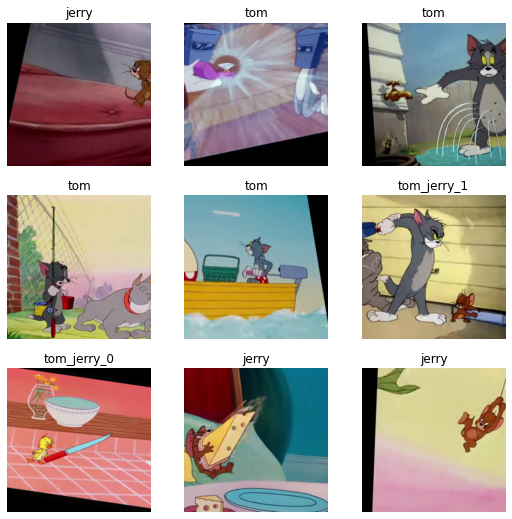

In [ ]:
dls.show_batch()

Creando el modelo de predicción mediante transfer learning de la arquitectura ResNet18

In [ ]:
learn = cnn_learner(dls,resnet18,metrics=accuracy).to_fp16()

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

**Amplicación**: Creación de modelo mediante el transfer learning usando una arquitectura distinta a ResNet

https://github.com/rwightman/pytorch-image-models/tree/master/timm/models

In [ ]:
learnEfficient = vision_learner(dls,efficientnet_b0,metrics=accuracy).to_fp16()

NameError: ignored

Entrenando la red

El entrenamiento usando la GPU cuesta aproximadamente 11 minutos

Sin embargo, al usar la CPU con el mismo tiempo empleado sólo se podría entrenar un par de épocas como máximo.

In [ ]:
%%time
learn.fine_tune(10,base_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.799326,0.876381,0.680365,01:03


epoch,train_loss,valid_loss,accuracy,time
0,1.219658,0.690917,0.738584,00:59
1,1.075597,0.549587,0.795662,00:59
2,0.956574,0.446658,0.836758,01:00
3,0.832939,0.397562,0.860731,00:59
4,0.708795,0.366762,0.875571,00:59
5,0.618413,0.349921,0.885845,00:59
6,0.547055,0.343034,0.883562,00:58
7,0.492210,0.336875,0.889269,00:58
8,0.462230,0.336353,0.892694,00:59
9,0.438254,0.332228,0.893836,00:59


CPU times: user 1min 38s, sys: 10.9 s, total: 1min 49s
Wall time: 10min 56s


In [ ]:
learn.export()

In [ ]:
Path().ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

Interpretación de los resultados

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

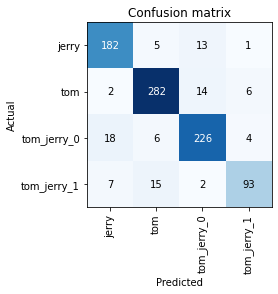

In [ ]:
interp.plot_confusion_matrix()

Evaluando el modelo en el conjunto de test

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))
dlsTest = dbTest.dataloaders(path,bs=128)

In [ ]:
learn.dls = dlsTest

In [ ]:
learn.validate()

(#2) [3.0644073486328125,0.3978102207183838]

Limpiar el dataset de imágenes que no deberían estar

In [ ]:
from fastai.vision.widgets import ImageClassifierCleaner

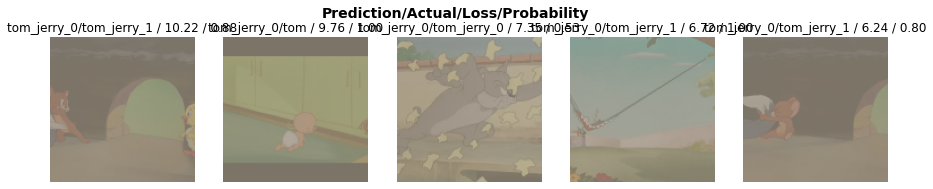

In [ ]:
interp.plot_top_losses(5,nrows=1)

In [ ]:
from fastai.vision.widgets import ImageClassifierCleaner
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

Poniendo el modelo en funcionamiento

In [ ]:
learn.export()

In [ ]:
defaults.device = torch.device('cpu')

In [ ]:
!wget https://www.pngall.com/wp-content/uploads/2016/07/Tom-And-Jerry-PNG-Picture.png -O tom_jerry.png

--2022-05-21 10:25:42--  https://www.pngall.com/wp-content/uploads/2016/07/Tom-And-Jerry-PNG-Picture.png
Resolving www.pngall.com (www.pngall.com)... 78.159.114.6
Connecting to www.pngall.com (www.pngall.com)|78.159.114.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/png]
Saving to: ‘tom_jerry.png’

tom_jerry.png           [  <=>               ] 286.92K   785KB/s    in 0.4s    

2022-05-21 10:25:43 (785 KB/s) - ‘tom_jerry.png’ saved [293802]



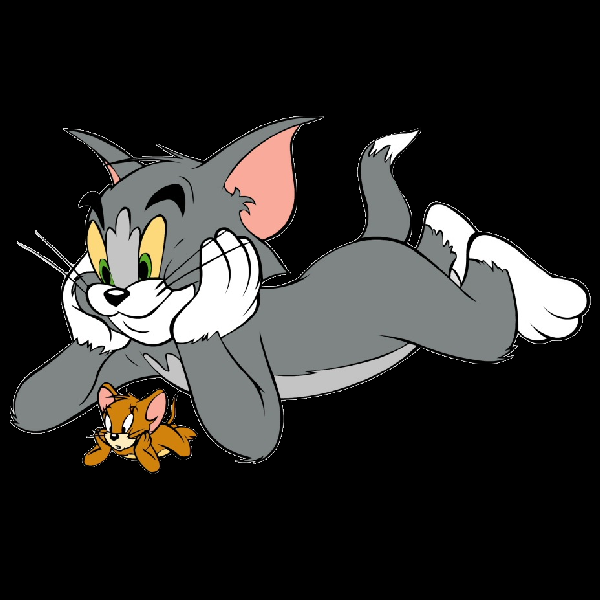

In [ ]:
import PIL
img = PILImage.create('tom_jerry.png')
img

In [ ]:
learn_inf = load_learner('export.pkl')

In [ ]:
pred_class,pred_idx,outputs=learn_inf.predict(img)
pred_class

'tom'

Ahora toca subir el modelo a HuggingFace

https://huggingface.co/spaces/paochoa/Entregable